In [13]:
import sys
import math
import warnings

import psycopg2
import wrds
import gzip

import seaborn as sns
import os
import quandl
import json
import zipfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import functools
import requests
import io

import urllib.request
from urllib.error import HTTPError
# from html_table_parser.parser import HTMLTableParser
import re

import plotnine as p9
from plotnine import ggplot, scale_x_date, guides, guide_legend, geom_bar, scale_y_continuous, \
    scale_color_identity, geom_line, geom_point, labs, theme_minimal, theme, element_blank, element_text, \
        geom_ribbon, geom_hline, aes, scale_size_manual, scale_color_manual, ggtitle

from datetime import datetime
import datetime

import pandas as pd
# import pandas_market_calendars as mcal
from pandas.plotting import autocorrelation_plot
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import scipy as sp
from scipy.stats import norm
import scipy.stats as stats

from statsmodels.tsa.stattools import coint
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

from collections import deque
from bisect import insort, bisect_left
from itertools import islice

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (10,6)

In [14]:
def max_drawdown(returns):
    local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns.iloc[0] > returns.iloc[1])) or 
       ((n > 0) and (returns.iloc[n-1] < returns.iloc[n]) and (returns.iloc[n+1] < returns.iloc[n]))] 
    
    local_min = [n for n in range(1, len(returns)) if ((n == len(returns)-1) and (returns.iloc[-1] < returns.iloc[-2])) or
            (returns.iloc[n-1] > returns.iloc[n]) and (returns.iloc[n+1] > returns.iloc[n])]
    
    def next_local_min(n):
        mins_after_n = [m for m in local_min if m > n]
        return mins_after_n[0] if mins_after_n else None
    
    drawdowns = [(n, next_local_min(n)) for n in local_max]
    drawdown_values = [returns.iloc[n] - returns.iloc[m] for (n, m) in drawdowns if m is not None]
    
    return np.max(drawdown_values) if drawdown_values else 0.0

In [15]:
def max_dd(returns, label):
    # Use .values to work with the underlying numpy array for compatibility
    cum_max = np.maximum.accumulate(returns.values)
    drawdown = cum_max - returns.values
    i = np.argmax(drawdown)  # Position of the max drawdown
    j = np.argmax(returns.values[:i])  # Position of the peak before the max drawdown
    
    plt.plot(returns.index, returns.values, label=label)  # Plot using the index for x-axis
    plt.plot([returns.index[i], returns.index[j]], [returns.values[i], returns.values[j]], 'o', color='Red', markersize=10)
    
    max_drawdown_value = np.abs(returns.values[j] - returns.values[i]) / returns.values[j]
    print(max_drawdown_value)
    return max_drawdown_value

In [16]:
long_short = pd.read_csv('simdata/PL_trade_1.csv')[['date','net_pos_value']].sort_values(by='date').reset_index(drop=True)
long_only = pd.read_csv('simdata/PL_trade_2.csv')[['date','net_pos_value']].sort_values(by='date').reset_index(drop=True)
short_only = pd.read_csv('simdata/PL_trade_3.csv')[['date','net_pos_value']].sort_values(by='date').reset_index(drop=True)

long_short['long_short_return'] = long_short['net_pos_value'] / long_short.loc[0, 'net_pos_value']
long_only['long_only_return'] = long_only['net_pos_value'] / long_only.loc[0, 'net_pos_value']
short_only['short_only_return'] = short_only['net_pos_value'] / short_only.loc[0, 'net_pos_value']

In [17]:
start_date = '2018-01-01'
end_date = '2023-02-28'
spy_data = pd.read_csv('spy_tickerdata.csv')[['date','adj_close']].sort_values(by='date').reset_index(drop=True)
spy_data = spy_data.loc[(spy_data['date'] >= start_date) & (spy_data['date'] <= end_date)].copy().reset_index(drop=True)
spy_data['SPY'] = spy_data['adj_close'] / spy_data.loc[0, 'adj_close']
spy_data

,date,adj_close,SPY
0,2018-01-02,242.893856,1.000000
1,2018-01-03,244.430187,1.006325
2,2018-01-04,245.460432,1.010567
3,2018-01-05,247.096172,1.017301
4,2018-01-08,247.548034,1.019161
...,...,...,...
1293,2023-02-22,392.530807,1.616059
1294,2023-02-23,394.618841,1.624656
1295,2023-02-24,390.403375,1.607300
1296,2023-02-27,391.733020,1.612775


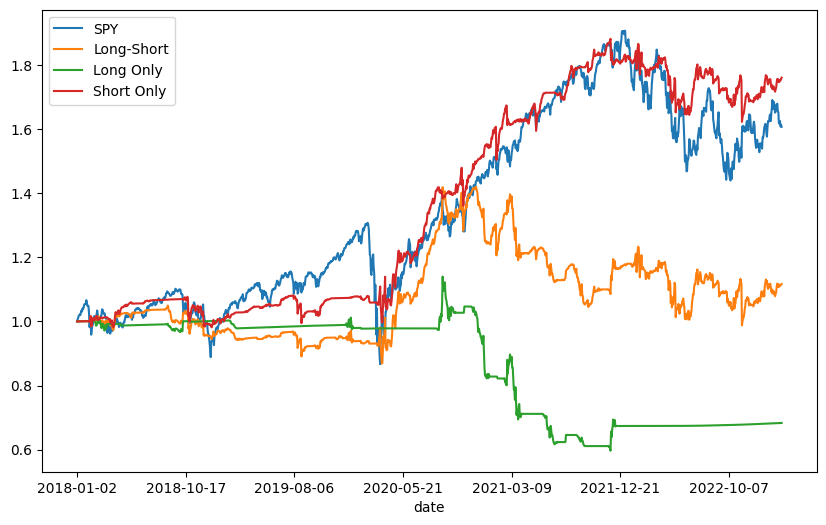

In [18]:
ret_data = spy_data[['date', 'SPY']].copy()
ret_data['Long-Short'] = long_short['long_short_return']
ret_data['Long Only'] = long_only['long_only_return']
ret_data['Short Only'] = short_only['short_only_return']
ret_data = ret_data.set_index('date')
ret_data.plot();

0.24497270037076455
0.3042381586224645
0.4762755640185654
0.1375138413928244


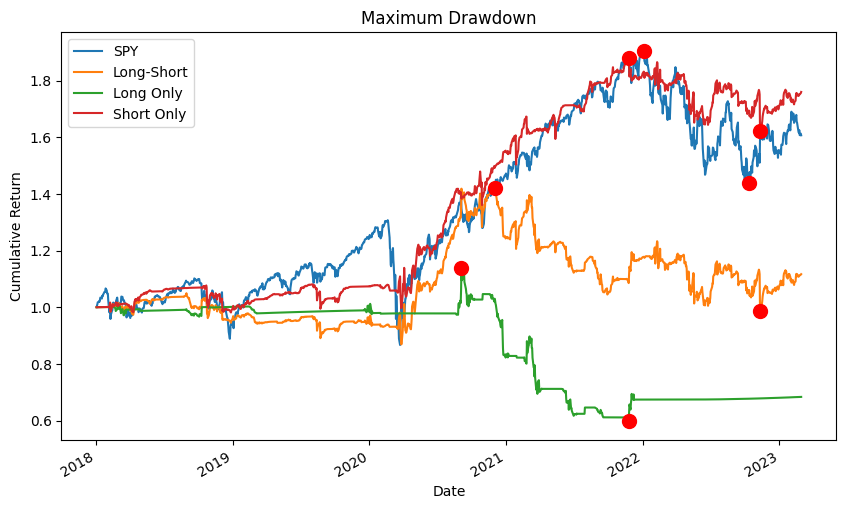

In [24]:
# Check if ret_data.index is already a datetime index
if not isinstance(ret_data.index, pd.DatetimeIndex):
    # Convert index to datetime if it's not
    ret_data.index = pd.to_datetime(ret_data.index)

# Prepare the plot
fig, ax = plt.subplots()

# Loop through columns if needed and plot
for col in ret_data.columns:
    max_dd(ret_data[col], label=col)  # Using column names as labels

# Set x-axis to only show year tick marks
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Optionally, adjust the format of the tick labels for better readability
plt.gcf().autofmt_xdate()  # Auto-format the x-axis labels to fit them better

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Maximum Drawdown')

plt.legend(loc='upper left')
plt.show()